In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import kagglehub
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import confusion_matrix
import statsmodels.formula.api as smf
#Pentru normalitate
from statsmodels.stats.stattools import jarque_bera
from scipy.stats import shapiro 
from scipy.stats import kstest, norm
#Pentru Homoschedasticitate
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_white
#Pentru multicolinaritate
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
def testare_homoschedasticitate(regression,actual):
    residuals = regression.resid
    exog = regression.model.exog
    print("Testul White")
    white_t = het_white(residuals,exog)
    print(white_t)
    print("Test Breuche-Pagan")
    bpt = het_breuschpagan(residuals,exog)
    print(bpt)
    plt.figure(figsize=(10,8))
    plt.scatter(actual,residuals)
    plt.xlabel("Valori reale")
    plt.ylabel("Valori estimate")
    plt.title("Real vs Estimat")
    plt.show()

In [3]:
def testare_normalitate(regresie,bins):
    #Testare normalitate
    reziduuri = regresie.resid
    jb = jarque_bera(reziduuri)
    print("jarque_bera")
    print(jb)
    print("SHAPIRO")
    shapiro_test = shapiro(reziduuri)
    print(shapiro_test)
    print("Kolmogov Smirnov")
    print(kstest(reziduuri, "norm", args=(reziduuri.mean(), reziduuri.std())))
    plt.figure(figsize=(10,6))
    plt.title("Distributia erorilor")
    plt.hist(reziduuri,bins=bins)
    plt.show()

In [4]:
df =  pd.read_csv("World-happiness-report-2024.csv",index_col="Country name")

In [307]:
df.head()

,Region,happy,upperwhisker,lowerwhisker,GDP_capita_logged,Social_support,Life_expectancy,Freedom,Generosity,Coruption,Dystopia + residual,Region_2
Country name,,,,,,,,,,,,
Finland,Western Europe,7.741,7.815,7.667,1.844,1.572,0.695,0.859,0.142,0.546,2.082,Europe
Denmark,Western Europe,7.583,7.665,7.500,1.908,1.520,0.699,0.823,0.204,0.548,1.881,Europe
Iceland,Western Europe,7.525,7.618,7.433,1.881,1.617,0.718,0.819,0.258,0.182,2.050,Europe
Sweden,Western Europe,7.344,7.422,7.267,1.878,1.501,0.724,0.838,0.221,0.524,1.658,Europe
Israel,Middle East and North Africa,7.341,7.405,7.277,1.803,1.513,0.740,0.641,0.153,0.193,2.298,Middle East


In [ ]:
# Verifca statele care au missing values pe oricare coloana
df[df.isna().any(axis=1) == True]

,Regional indicator,Ladder score,upperwhisker,lowerwhisker,Log GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Dystopia + residual
Country name,,,,,,,,,,,
Bahrain,Middle East and North Africa,5.959,6.153,5.766,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Tajikistan,Commonwealth of Independent States,5.281,5.361,5.201,NaN,NaN,NaN,NaN,NaN,NaN,NaN
State of Palestine,Middle East and North Africa,4.879,5.006,4.753,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
df.dropna(inplace=True)

In [14]:
# print(df['Regional indicator'].drop_duplicates())
Asia = ['Southeast Asia','East Asia','South Asia']
Europe = ['Western Europe','Central and Eastern Europe']
North_America = ['United States','Canada']
Australia = ['Australia','New Zealand']
Africa = ['Sub-Saharan Africa']
Countries_not_in_middle_east =['Ukraine','Moldova','Georgia']
African_countries = ["Libya","Algeria","Morocco","Tunisia","Egypt"]

In [15]:
# print(Asia)
# print(Europe)
# print(North_America)
# print(Australia)
# print(Africa)
# print(Countries_not_in_middle_east)
# print(African_countries)

In [16]:
df.rename(columns={
    'Log GDP per capita':'GDP_capita_logged',
    'Perceptions of corruption':'Coruption',
    'Healthy life expectancy':'Life_expectancy',
    'Social support':'Social_support',
    'Ladder score':'happy',
    'Regional indicator':'Region',
    'Freedom to make life choices':'Freedom'
},inplace=True)

In [17]:
df['Region_2'] = df.apply(lambda x: 'Asia' if x['Region'] in Asia else
                                              'Europe' if x['Region'] in Europe else
                                              'North_America' if x.name in North_America else
                                              'Australia' if x.name in Australia else
                                              'Africa' if x['Region'] in Africa else
                                              'South America' if x['Region'] =='Latin America and Caribbean' else
                                              'Europe' if x['Region']=='Commonwealth of Independent States' and x.name in Countries_not_in_middle_east else
                                              'Middle East' if x['Region']=='Commonwealth of Independent States' and x.name not in Countries_not_in_middle_east else
                                              'Africa' if x.name in African_countries else 'Middle East',axis=1)

### Spargere in train_test stratificat

In [200]:
df_train = df.groupby('Region').sample(frac=0.75)
index_train = df_train.index
conditie = ~df.index.isin(index_train)
df_test = df[conditie].copy()

In [203]:
print(len(df_test['Region_2'].value_counts(normalize=True)))
print(len(df_train['Region_2'].value_counts(normalize=True)))

6
7


### Inceput Regresie

In [313]:
regresie = smf.ols('happy ~ Social_support + Coruption +GDP_capita_logged + Freedom',data=df_train).fit()
print(regresie.summary())
exog = regresie.model.exog
fit = regresie.fittedvalues
weigths = 1 / (np.power(fit,2))
wls = sm.WLS(df_train.loc[df_train.dropna().index,'happy'],exog=exog,weights=weigths).fit()

                            OLS Regression Results                            
Dep. Variable:                  happy   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     104.4
Date:                Mon, 22 Dec 2025   Prob (F-statistic):           1.24e-34
Time:                        17:41:34   Log-Likelihood:                -69.613
No. Observations:                 104   AIC:                             149.2
Df Residuals:                      99   BIC:                             162.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             1.5713      0.22

Testul White
(16.69172877725433, 0.27297814260738185, 1.2153682908114192, 0.27869714469140244)
Test Breuche-Pagan
(10.588098065913282, 0.03160485775068882, 2.8053751364174673, 0.02970039959883563)


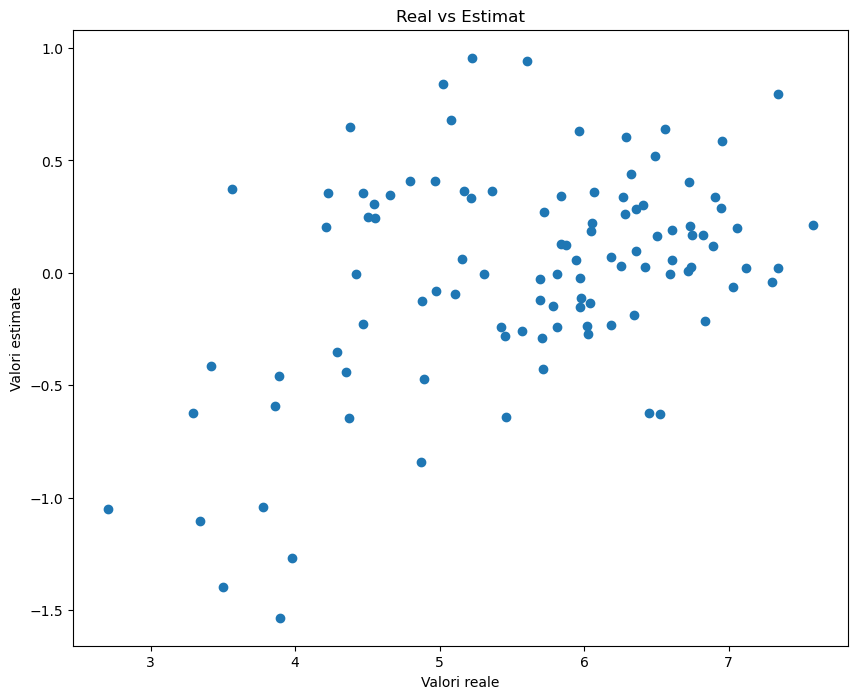

In [314]:
testare_homoschedasticitate(regresie,df_train.loc[df_train.index,'happy'])

In [315]:
print(wls.summary())

                            WLS Regression Results                            
Dep. Variable:                  happy   R-squared:                       0.792
Model:                            WLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                     94.30
Date:                Mon, 22 Dec 2025   Prob (F-statistic):           6.89e-33
Time:                        17:41:35   Log-Likelihood:                -81.713
No. Observations:                 104   AIC:                             173.4
Df Residuals:                      99   BIC:                             186.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6416      0.205      8.024      0.0

Testul White
(15.669310681561711, 0.33398339170328983, 1.1277173001167689, 0.3457131549474621)
Test Breuche-Pagan
(9.30015790478354, 0.05401954067860422, 2.4306155432863132, 0.05256044395681784)


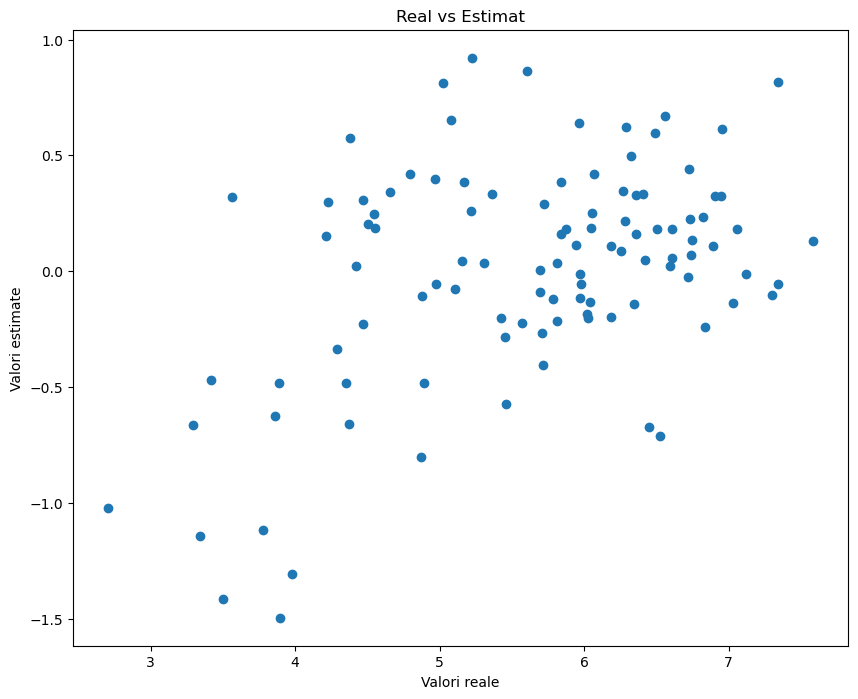

In [316]:
testare_homoschedasticitate(wls,df_train.loc[df_train.index,'happy'])

In [317]:
model_corectat = regresie.get_robustcov_results(cov_type='HC3')
print(model_corectat.summary())

                            OLS Regression Results                            
Dep. Variable:                  happy   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     90.57
Date:                Mon, 22 Dec 2025   Prob (F-statistic):           3.29e-32
Time:                        17:41:41   Log-Likelihood:                -69.613
No. Observations:                 104   AIC:                             149.2
Df Residuals:                      99   BIC:                             162.4
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             1.5713      0.26

Testul White
(16.69172877725433, 0.27297814260738185, 1.2153682908114192, 0.27869714469140244)
Test Breuche-Pagan
(10.588098065913282, 0.03160485775068882, 2.8053751364174673, 0.02970039959883563)


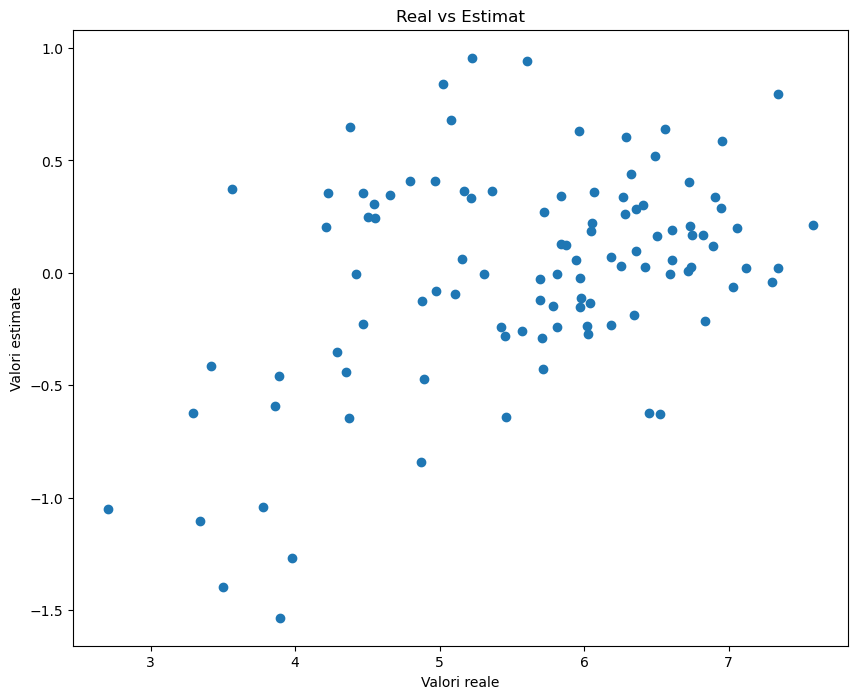

In [318]:
testare_homoschedasticitate(model_corectat,df.loc[df_train.index,'happy'])

jarque_bera
(17.88474067760367, 0.00013073079635581247, -0.8425307896959793, 4.134819510906844)
SHAPIRO
ShapiroResult(statistic=0.9510920643806458, pvalue=0.0007470402051694691)
Kolmogov Smirnov
KstestResult(statistic=0.09157428938967882, pvalue=0.3275636709468944, statistic_location=-0.005451059816206083, statistic_sign=-1)


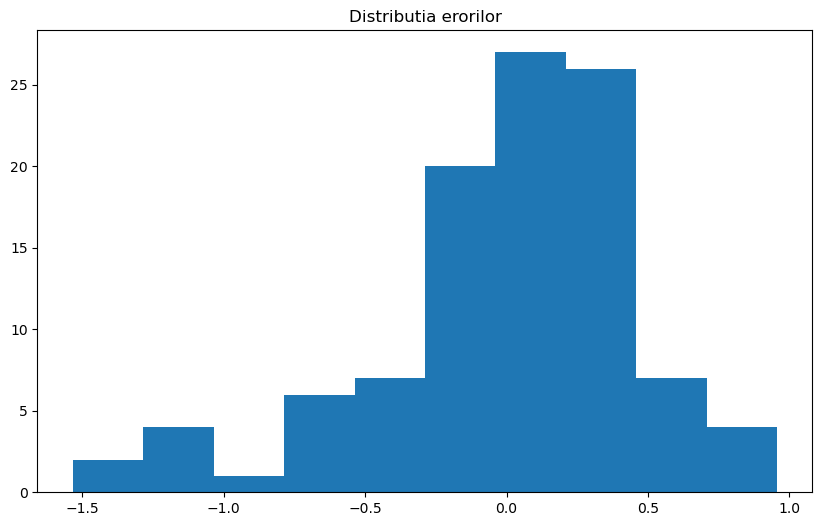

In [222]:
#Testare normalitate
testare_normalitate(regresie=regresie,bins=10)

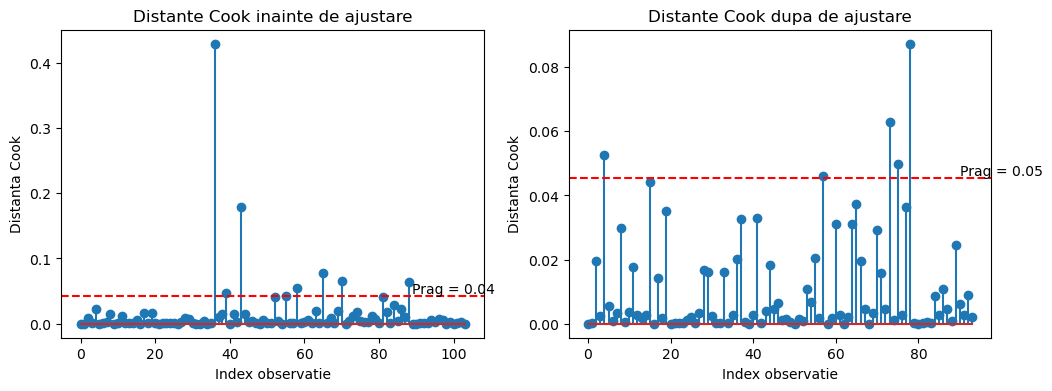

jarque_bera
(0.3447305718954909, 0.841671666175658, -0.14790425008007022, 2.9773362081362325)
SHAPIRO
ShapiroResult(statistic=0.9858304858207703, pvalue=0.4078853130340576)
Kolmogov Smirnov
KstestResult(statistic=0.06280960112024919, pvalue=0.8293937204716522, statistic_location=-0.009818053597879128, statistic_sign=-1)


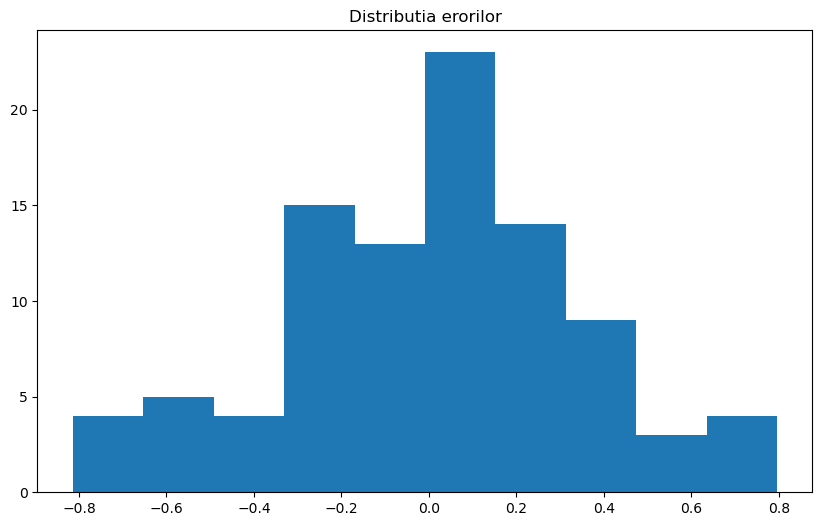

In [254]:
influence = regresie.get_influence()
cooks_d, p_values = influence.cooks_distance
df_with_cook = df_train.copy()
df_with_cook['cooks_d'] = cooks_d
influential = df_with_cook[df_with_cook['cooks_d'] > 4 / len(df_with_cook)]
df_with_cook.drop(index=influential.index,inplace=True)

figura, axe = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
ax1,ax2 = axe

ax1.stem(cooks_d)
ax1.set_xlabel('Index observatie')
ax1.set_ylabel("Distanta Cook")
ax1.set_title("Distante Cook inainte de ajustare")
ax1.axhline(4 / len(df_with_cook),linestyle="--",color='red')
ax1.text(100,
         4 / len(df_with_cook),
        f"Prag = {np.round(4 / len(df_with_cook),2)}",
        va="bottom",
        ha="center"
        )
regresie_cook = smf.ols('happy ~Social_support + '
                            '+ Coruption +GDP_capita_logged + Freedom',data=df_with_cook).fit()
exog = regresie.model.exog
fit = regresie.fittedvalues


influence = regresie_cook.get_influence()
cooks_d, p_values = influence.cooks_distance
# df_with_cook = df.copy()
df_with_cook['cooks_d'] = cooks_d
influential = df_with_cook[df_with_cook['cooks_d'] > 4 / len(df_with_cook)]
df_with_cook.drop(index=influential.index,inplace=True)
ax2.stem(cooks_d)
ax2.set_xlabel('Index observatie')
ax2.set_ylabel("Distanta Cook")
ax2.set_title("Distante Cook dupa de ajustare")
ax2.axhline(4 / len(df_with_cook),linestyle="--",color="red")
ax2.text(100,
         4 / len(df_with_cook),
        f"Prag = {np.round(4 / len(df_with_cook),2)}",
        va="bottom",
        ha="center"
        )
plt.show()

testare_normalitate(regresie=regresie_cook,bins=10)

In [319]:

# influence = regresie_cook.get_influence()
# cooks_d, p_values = influence.cooks_distance
# # df_with_cook = df.copy()
# df_with_cook['cooks_d'] = cooks_d
# influential = df_with_cook[df_with_cook['cooks_d'] > 4 / len(df_with_cook)]
# df_with_cook.drop(index=influential.index,inplace=True)
# plt.stem(cooks_d)
# plt.xlabel('Observation')
# plt.ylabel("Cook's Distance")
# plt.show()


In [320]:
regresie_cook = smf.ols('happy ~Social_support + '
                            '+ Coruption +GDP_capita_logged + Freedom',data=df_with_cook).fit()
print(regresie_cook.summary())
exog = regresie_cook.model.exog
fit = regresie_cook.fittedvalues
weigths = 1 / (np.power(fit,2))
# wls = sm.WLS(df.loc[df.dropna().index,'happy'],exog=exog,weights=weigths).fit()

                            OLS Regression Results                            
Dep. Variable:                  happy   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     172.8
Date:                Mon, 22 Dec 2025   Prob (F-statistic):           2.17e-39
Time:                        17:43:32   Log-Likelihood:                -17.152
No. Observations:                  88   AIC:                             44.30
Df Residuals:                      83   BIC:                             56.69
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             1.9628      0.16

Testul White
(10.568835104881831, 0.7195257172604677, 0.7117150565753808, 0.755818520480286)
Test Breuche-Pagan
(4.751228634475025, 0.31378821675785284, 1.1842576478694316, 0.32380193819947223)


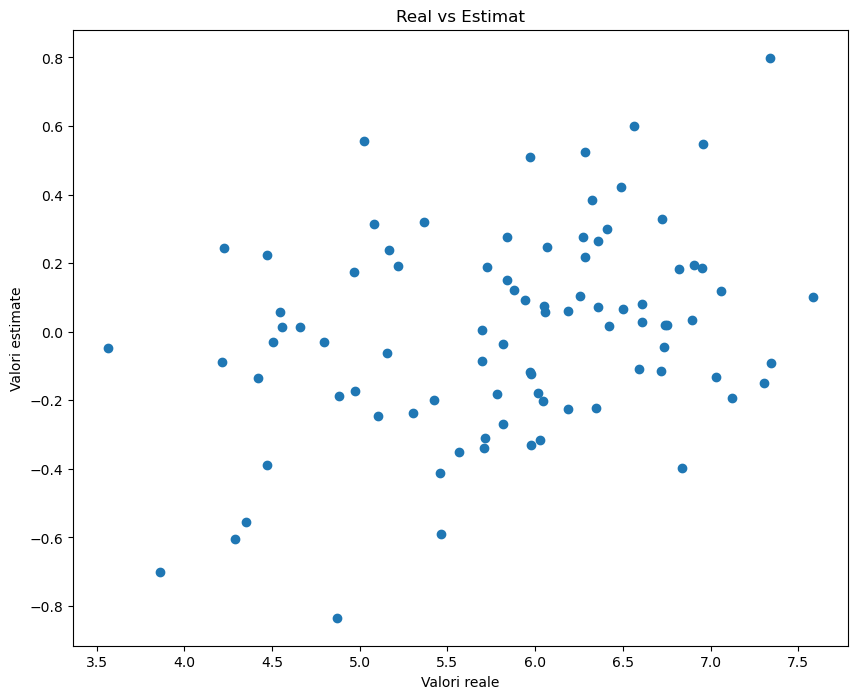

In [321]:
testare_homoschedasticitate(regresie_cook,df_with_cook.loc[df_with_cook.index,'happy'])

jarque_bera
(0.7860823053943857, 0.675000968904075, -0.11011061470210895, 3.407294357202592)
SHAPIRO
ShapiroResult(statistic=0.9921320080757141, pvalue=0.8818252086639404)
Kolmogov Smirnov
KstestResult(statistic=0.04382637305820633, pvalue=0.9932049184864256, statistic_location=-0.24582258223671438, statistic_sign=-1)


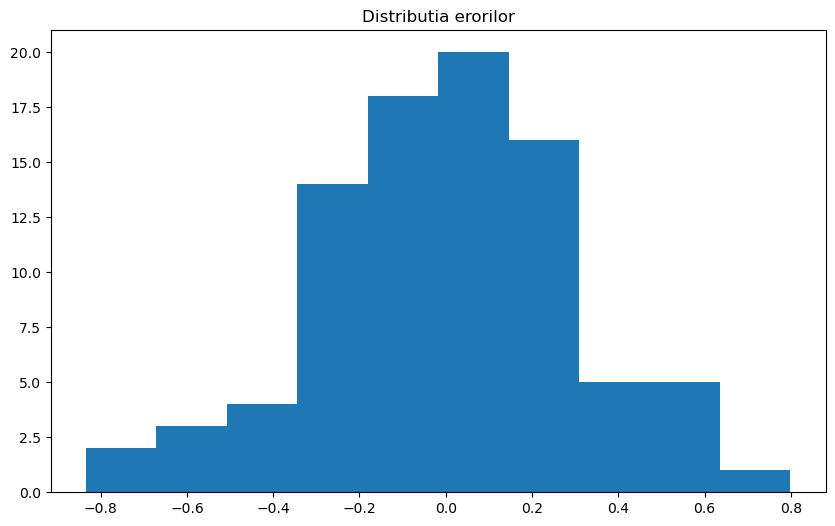

In [322]:
testare_normalitate(regresie_cook,bins=10)

Verificare Multicoloniaritate + Matrice de corelatii

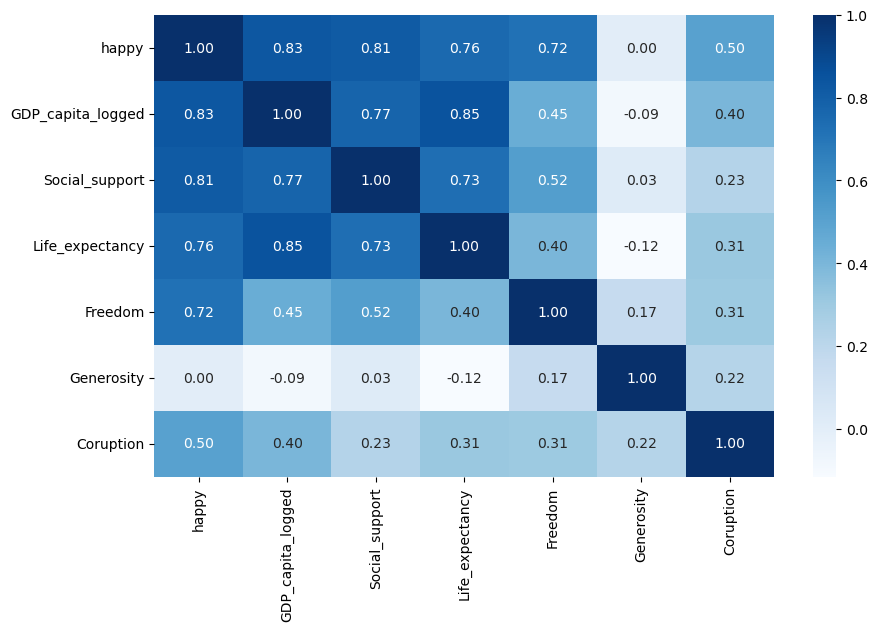

In [260]:
col = list(df_with_cook.drop(columns=["Region_2","cooks_d","upperwhisker","lowerwhisker","Dystopia + residual"],inplace=False).columns)[1:]
corel_matrix = df_with_cook[col].corr()

plt.figure(figsize=(10,6))
sns.heatmap(data=corel_matrix,fmt=".2f",cmap="Blues",annot=True)
plt.show()

In [261]:
vif = {k:variance_inflation_factor(exog,i) for k,i in zip(regresie_cook.params.index,range(len(regresie_cook.params.index)))}
vif

{'Intercept': 24.79300986611174,
 'Social_support': 2.894406621282594,
 'Coruption': 1.2750644910102558,
 'GDP_capita_logged': 2.8844253519767733,
 'Freedom': 1.4551382588063568}

## To do pt Philipe

1. df.describe() si scrii intr-un document word concluziile pe care le obtii din date (Pt proiect)
2. Cauta surse de date care sa fie cat de cat similare cu ceea ce avem noi (GDP per capita!!!) (Pt proiect)
3. Reformuleaza definitiile de pe kaggle a.i. sa aiba  (Pt proiect)
4. Joaca-te cu diverse forme ale modelului: Baga si scoate variabile din model, vezi care sunt sau nu  (Pt tine + pt proiect)
5. Testeaza ipotezele de normalitate, homoschedasticitate, multicoliniaritate (Pt tine)
6. Intrepreteaza parametriii (Pt tine)

In [150]:
# regresie.summary()

# Rezultate finale obtinute
###
#
Eliminarea a 18 instante utilizand distante Cook, obtinem urmatorul model
### Forma finala a modelului: 
### Happines Index = 1.64 + 0.71 * Coruptie + 1.66 * ln(PIB) + 2.58 * IndiceLibertate

In [262]:
regresie_cook = smf.ols('happy ~ Coruption +GDP_capita_logged + Freedom',data=df_with_cook).fit()
print(regresie_cook.summary())
exog = regresie_cook.model.exog
fit = regresie_cook.fittedvalues
weigths = 1 / (np.power(fit,2))

                            OLS Regression Results                            
Dep. Variable:                  happy   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     169.5
Date:                Mon, 22 Dec 2025   Prob (F-statistic):           1.61e-35
Time:                        16:25:21   Log-Likelihood:                -29.455
No. Observations:                  88   AIC:                             66.91
Df Residuals:                      84   BIC:                             76.82
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             2.1373      0.18

jarque_bera
(0.12720102535496533, 0.9383797954946335, -0.08476319664795108, 2.922850854124913)
SHAPIRO
ShapiroResult(statistic=0.9936618804931641, pvalue=0.9515872597694397)
Kolmogov Smirnov
KstestResult(statistic=0.05225173044352466, pvalue=0.9596410939989677, statistic_location=-0.38378413022676927, statistic_sign=1)


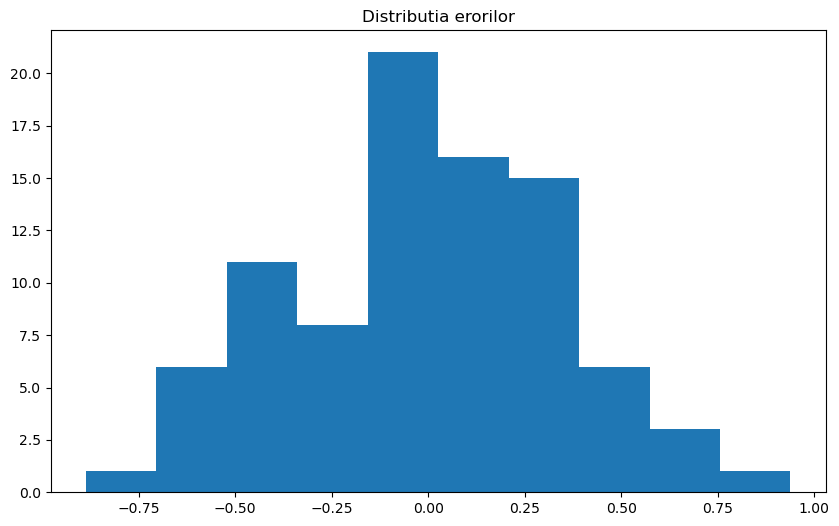

In [263]:
testare_normalitate(regresie=regresie_cook,bins=10)

Testul White
(15.396860931032343, 0.08059595231893735, 1.7973709043512185, 0.0763559140378347)
Test Breuche-Pagan
(8.220521507800957, 0.041667403125131994, 2.841817495782775, 0.04082071952864869)


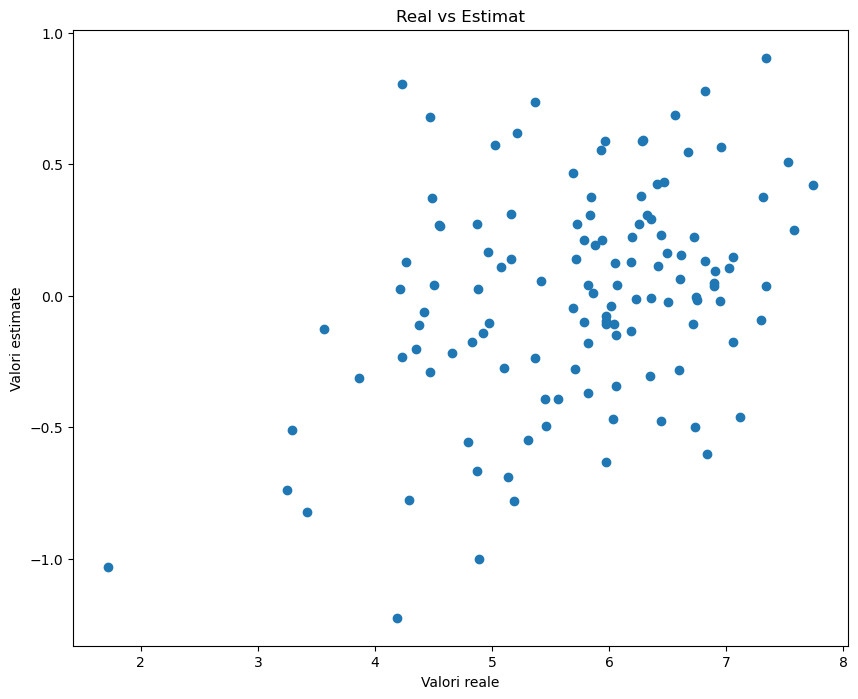

In [159]:
testare_homoschedasticitate(regression=regresie_cook,actual=df_with_cook.loc[df_with_cook.dropna().index,'happy'])

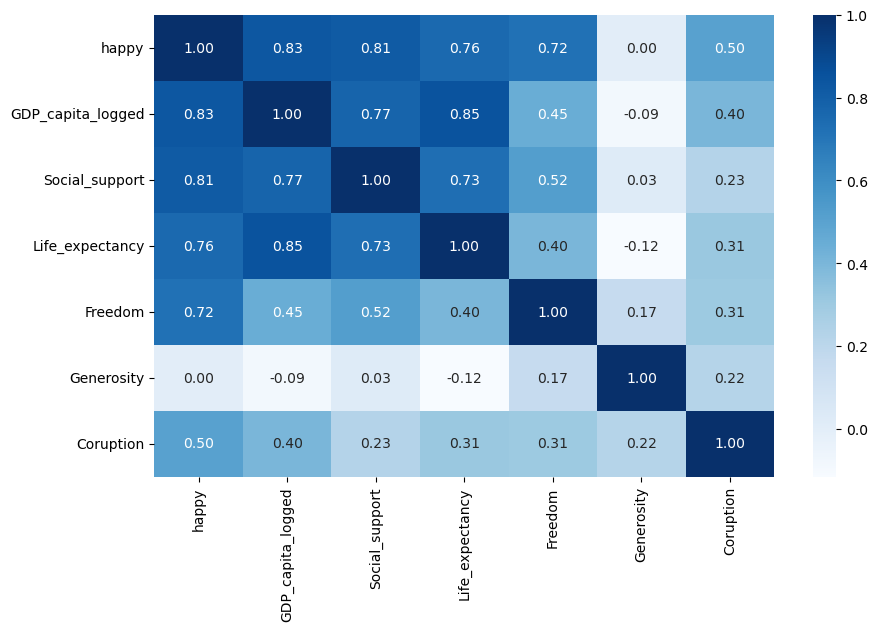

In [266]:
col = list(df_with_cook.drop(columns=["Region_2","cooks_d","upperwhisker","lowerwhisker","Dystopia + residual"],inplace=False).columns)[1:]
corel_matrix = df_with_cook[col].corr()

plt.figure(figsize=(10,6))
sns.heatmap(data=corel_matrix,fmt=".2f",cmap="Blues",annot=True)
plt.show()

In [267]:
vif = {k:variance_inflation_factor(exog,i) for k,i in zip(regresie_cook.params.index,range(len(regresie_cook.params.index)))}
vif

{'Intercept': 23.701350278736506,
 'Coruption': 1.2207711991877521,
 'GDP_capita_logged': 1.3846594844274165,
 'Freedom': 1.2828341984580143}

# Evaluare a perfomantelor modelului

In [300]:
parametrii = ['Coruption','GDP_capita_logged','Freedom']
X = df_test[parametrii]
parametrii.append('happy')
real = df_test['happy']
rezultate_regresie = df_test[parametrii].copy()
rezultate_regresie.rename(columns={'happy':'Actual'},inplace=True)
rezultate_regresie['predicted'] = regresie_cook.predict(X)
estimat = rezultate_regresie['predicted']

Calcul RMSE, R2, MAE, MAPE, R2-Ajustat

In [323]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

RMSE = np.sqrt(np.mean(np.power(real -estimat,2)))
print("RMSE: "+ str(RMSE))
MSE = np.mean(np.power(real-estimat,2))
print("MSE: "+ str(MSE))

r2_testData = r2_score(real,estimat)
print("R-squared: "+ str(r2_testData))

MAE = mean_absolute_error(real, estimat)
print("MAE: "+ str(MAE))

# mask = y_test != 0
# mape = np.mean(np.abs((y_test[mask] - y_pred[mask]) / y_test[mask])) * 100

RMSE: 0.8041765739041439
MSE: 0.6466999620162069
R-squared: 0.6676794704154825
MAE: 0.5987901741202262


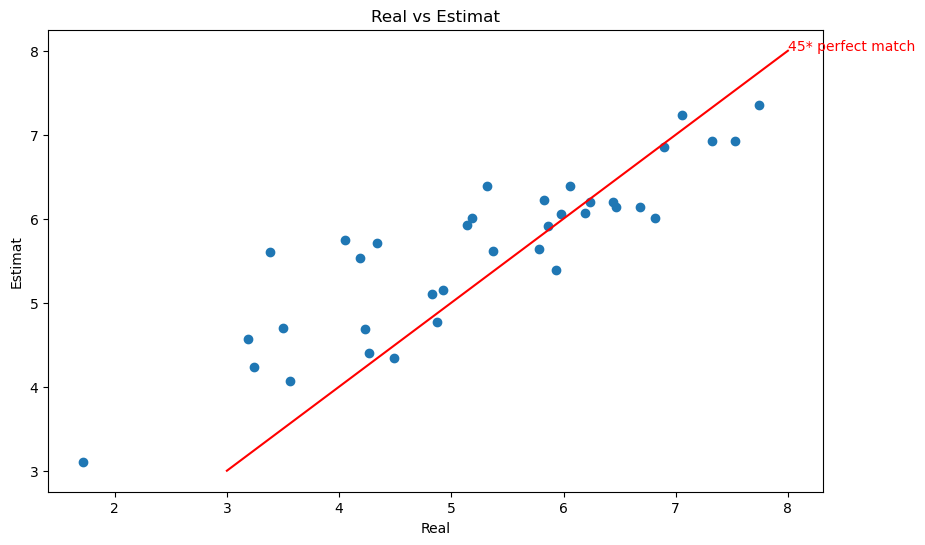

In [297]:
plt.figure(figsize=(10,6))
plt.scatter(rezultate_regresie['Actual'],rezultate_regresie['predicted'])
plt.xlabel("Real")
plt.ylabel("Estimat")
plt.title("Real vs Estimat")
x = np.linspace(3, 8, 100)
plt.plot(x, x,color='red')
plt.text(8,8,"45* perfect match",color='red')
plt.show()

# To do
###
1. Spargere Train Test ✅
2. Antrenare pe Train, testare pe test ✅
3. Evaluarea RMSE, R2 pe test data ✅
4. Adaugare polinomiala
5. Adaugare termeni de regularizare